In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0610/weights_KD_segformer_0610_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 8s 859ms/step - loss: 1.4004e-05
Average validation loss: 0.6699107885360718
4/4 [==============================] - 8s 872ms/step - loss: 1.4004e-05 - val_loss: 0.6699
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 11s 746ms/step - loss: 1.1528e-05 - val_loss: 0.6699
Average validation loss: 0.541538417339325
4/4 [==============================] - 11s 762ms/step - loss: 1.1528e-05 - val_loss: 0.6057
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 13s 689ms/step - loss: 9.4572e-06 - val_loss: 0.6057
Average validation loss: 0.4401378929615021
4/4 [==============================] - 14s 699ms/step - 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 698ms/step - loss: 7.5044e-07
Average validation loss: 0.002126853563822806
8/8 [==============================] - 6s 710ms/step - loss: 7.5044e-07 - val_loss: 0.0021
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 700ms/step - loss: 7.3551e-07 - val_loss: 0.0021
Average validation loss: 0.003071686835028231
8/8 [==============================] - 11s 712ms/step - loss: 7.3551e-07 - val_loss: 0.0026
Epoch 3/10
8/8 [==============================] - 17s 708ms/step - loss: 7.1972e-07 - val_loss: 0.0026
Average validation loss: 0.0034565423848107457
8/8 [==============================] - 17s 720ms/step - loss: 7.1972e-07 - val_loss: 0.0029
Epoch 4/10
8/8 [==============================] - 23s 705ms/step - loss: 7.1342e-07 - val_loss: 0.0029
Average validation loss: 0.0

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 709ms/step - loss: 1.0867e-06
Average validation loss: 0.144346237527922
12/12 [==============================] - 9s 718ms/step - loss: 1.0867e-06 - val_loss: 0.1443
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 731ms/step - loss: 1.0668e-06 - val_loss: 0.1443
Average validation loss: 0.08260735137446318
12/12 [==============================] - 18s 742ms/step - loss: 1.0668e-06 - val_loss: 0.1135
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 708ms/step - loss: 1.0580e-06 - val_loss: 0.1135
Average validation loss: 0.07312839365719508
12/12 [==============================] - 2

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 699ms/step - loss: 6.3339e-07
Average validation loss: 0.061426395375747234
16/16 [==============================] - 11s 711ms/step - loss: 6.3339e-07 - val_loss: 0.0614
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 694ms/step - loss: 6.4462e-07 - val_loss: 0.0614
Average validation loss: 0.06500904026324861
16/16 [==============================] - 23s 705ms/step - loss: 6.4462e-07 - val_loss: 0.0632
Epoch 3/10
16/16 [==============================] - 34s 716ms/step - loss: 5.9630e-07 - val_loss: 0.0632
Average validation loss: 0.05848356484784745
16/16 [==============================] - 34s 727ms/step - loss: 5.9630e-07 - val_loss: 0.0616
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/we

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 704ms/step - loss: 4.3642e-07
Average validation loss: 0.11009672300424427
20/20 [==============================] - 14s 714ms/step - loss: 4.3642e-07 - val_loss: 0.1101
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 711ms/step - loss: 4.0916e-07 - val_loss: 0.1101
Average validation loss: 0.08470171756343917
20/20 [==============================] - 29s 721ms/step - loss: 4.0916e-07 - val_loss: 0.0974
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 43s 721ms/step - loss: 3.9150e-07 - val_loss: 0.0974
Average validation loss: 0.0944054544903338
20/20 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 18s 742ms/step - loss: 9.7292e-07
Average validation loss: 0.14257002249360085
24/24 [==============================] - 18s 752ms/step - loss: 9.7292e-07 - val_loss: 0.1426
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 713ms/step - loss: 8.8106e-07 - val_loss: 0.1426
Average validation loss: 0.07392087951302528
24/24 [==============================] - 35s 723ms/step - loss: 8.8106e-07 - val_loss: 0.1082
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 53s 713ms/step - loss: 7.5033e-07 - val_loss: 0.1082
Average validation loss: 0.07252275322874387
24/24 [==============================]

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 715ms/step - loss: 5.1015e-07
Average validation loss: 0.12102383151650428
40/40 [==============================] - 29s 725ms/step - loss: 5.1015e-07 - val_loss: 0.1210
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 57s 701ms/step - loss: 4.6693e-07 - val_loss: 0.1210
Average validation loss: 0.1224950011819601
40/40 [==============================] - 57s 712ms/step - loss: 4.6693e-07 - val_loss: 0.1218
Epoch 3/10
40/40 [==============================] - 86s 711ms/step - loss: 4.1288e-07 - val_loss: 0.1218
Average validation loss: 0.11901635378599167
40/40 [==============================] - 86s 722ms/step - loss: 4.1288e-07 - val_loss: 0.1208
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weig

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 33s 695ms/step - loss: 2.2577e-07
Average validation loss: 0.10216327314265072
48/48 [==============================] - 34s 705ms/step - loss: 2.2577e-07 - val_loss: 0.1022
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 67s 691ms/step - loss: 1.9336e-07 - val_loss: 0.1022
Average validation loss: 0.074470428051427
48/48 [==============================] - 68s 701ms/step - loss: 1.9336e-07 - val_loss: 0.0883
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 101s 705ms/step - loss: 1.6863e-07 - val_loss: 0.0883
Average validation loss: 0.06746603296293567
48/48 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 717ms/step - loss: 2.1345e-07
Average validation loss: 0.0885271170575704
56/56 [==============================] - 41s 727ms/step - loss: 2.1345e-07 - val_loss: 0.0885
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 81s 718ms/step - loss: 1.7160e-07 - val_loss: 0.0885
Average validation loss: 0.0896769075521401
56/56 [==============================] - 82s 729ms/step - loss: 1.7160e-07 - val_loss: 0.0891
Epoch 3/10
56/56 [==============================] - 122s 716ms/step - loss: 1.4598e-07 - val_loss: 0.0891
Average validation loss: 0.08854515893783953
56/56 [==============================] - 122s 726ms/step - loss: 1.4598e-07 - val_loss: 0.0889
Epoch 4/10
56/56 [==============================] - 162s 717ms/step - loss: 1.3149e-07 - val_loss: 0.0889
Average validat

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 726ms/step - loss: 2.3452e-07
Average validation loss: 0.06651239411439747
64/64 [==============================] - 47s 736ms/step - loss: 2.3452e-07 - val_loss: 0.0665
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 93s 711ms/step - loss: 1.8216e-07 - val_loss: 0.0665
Average validation loss: 0.0630517604877241
64/64 [==============================] - 93s 721ms/step - loss: 1.8216e-07 - val_loss: 0.0648
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 139s 713ms/step - loss: 1.4173e-07 - val_loss: 0.0648
Average validation loss: 0.0678180503891781
64/64 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 722ms/step - loss: 1.6736e-07
Average validation loss: 0.071943623945117
72/72 [==============================] - 53s 732ms/step - loss: 1.6736e-07 - val_loss: 0.0719
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 104s 711ms/step - loss: 1.2643e-07 - val_loss: 0.0719
Average validation loss: 0.056000818498432636
72/72 [==============================] - 105s 721ms/step - loss: 1.2643e-07 - val_loss: 0.0640
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 156s 711ms/step - loss: 1.0455e-07 - val_loss: 0.0640
Average validation loss: 0.06582737455351485
72/72 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 723ms/step - loss: 1.4977e-07
Average validation loss: 0.04374742936342955
80/80 [==============================] - 59s 733ms/step - loss: 1.4977e-07 - val_loss: 0.0437
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 116s 717ms/step - loss: 1.3034e-07 - val_loss: 0.0437
Average validation loss: 0.05323019521310925
80/80 [==============================] - 117s 727ms/step - loss: 1.3034e-07 - val_loss: 0.0485
Epoch 3/10
80/80 [==============================] - 175s 721ms/step - loss: 1.0728e-07 - val_loss: 0.0485
Average validation loss: 0.06569786574691534
80/80 [==============================] - 175s 731ms/step - loss: 1.0728e-07 - val_loss: 0.0542
Epoch 4/10
80/80 [==============================] - 233s 717ms/step - loss: 9.2183e-08 - val_loss: 0.0542
Average va

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 717ms/step - loss: 3.2739e-07
Average validation loss: 0.13486976236648238
96/96 [==============================] - 70s 726ms/step - loss: 3.2739e-07 - val_loss: 0.1349
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 139s 720ms/step - loss: 2.2892e-07 - val_loss: 0.1349
Average validation loss: 0.10849274797753121
96/96 [==============================] - 140s 730ms/step - loss: 2.2892e-07 - val_loss: 0.1217
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 209s 720ms/step - loss: 1.8370e-07 - val_loss: 0.1217
Average validation loss: 0.13864930788986385
96/96 [==========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 716ms/step - loss: 3.4989e-07
Average validation loss: 0.081507248369356
120/120 [==============================] - 87s 726ms/step - loss: 3.4989e-07 - val_loss: 0.0815
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 174s 722ms/step - loss: 2.5230e-07 - val_loss: 0.0815
Average validation loss: 0.1132516990415752
120/120 [==============================] - 175s 732ms/step - loss: 2.5230e-07 - val_loss: 0.0974
Epoch 3/10
120/120 [==============================] - 261s 717ms/step - loss: 2.0164e-07 - val_loss: 0.0974
Average validation loss: 0.09071656887729963
120/120 [==============================] - 262s 727ms/step - loss: 2.0164e-07 - val_loss: 0.0952
Epoch 4/10
120/120 [==============================] - 348s 714ms/step - loss: 1.6957e-07 - val_loss: 0.0952

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 103s 715ms/step - loss: 2.1246e-07
Average validation loss: 0.0571621245601111
144/144 [==============================] - 104s 725ms/step - loss: 2.1246e-07 - val_loss: 0.0572
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 208s 719ms/step - loss: 1.5933e-07 - val_loss: 0.0572
Average validation loss: 0.08296340332728708
144/144 [==============================] - 209s 728ms/step - loss: 1.5933e-07 - val_loss: 0.0701
Epoch 3/10
144/144 [==============================] - 312s 714ms/step - loss: 1.3305e-07 - val_loss: 0.0701
Average validation loss: 0.08207691566915148
144/144 [==============================] - 314s 724ms/step - loss: 1.3305e-07 - val_loss: 0.0741
Epoch 4/10
144/144 [==============================] - 417s 720ms/step - loss: 1.1574e-07 - val_loss: 0.

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 716ms/step - loss: 1.4619e-07
Average validation loss: 0.08534986039157957
160/160 [==============================] - 116s 726ms/step - loss: 1.4619e-07 - val_loss: 0.0853
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 231s 719ms/step - loss: 1.2532e-07 - val_loss: 0.0853
Average validation loss: 0.0696046112687327
160/160 [==============================] - 233s 729ms/step - loss: 1.2532e-07 - val_loss: 0.0775
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 348s 716ms/step - loss: 1.0414e-07 - val_loss: 0.0775
Average validation loss: 0.06536345080239699
160/160 [=============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 143s 714ms/step - loss: 2.4233e-07
Average validation loss: 0.1092851784825325
200/200 [==============================] - 145s 724ms/step - loss: 2.4233e-07 - val_loss: 0.1093
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 289s 718ms/step - loss: 1.9916e-07 - val_loss: 0.1093
Average validation loss: 0.07416658459231257
200/200 [==============================] - 291s 729ms/step - loss: 1.9916e-07 - val_loss: 0.0917
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 434s 716ms/step - loss: 1.7397e-07 - val_loss: 0.0917
Average validation loss: 0.05822144055739045
200/200 [=============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:38 - loss: 7.8545e-08

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 167s 697ms/step - loss: 2.1547e-07
Average validation loss: 0.09347987309447489
240/240 [==============================] - 170s 706ms/step - loss: 2.1547e-07 - val_loss: 0.0935
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_100\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 337s 697ms/step - loss: 1.5276e-07 - val_loss: 0.0935
Average validation loss: 0.09796597606036812
240/240 [==============================] - 339s 707ms/step - loss: 1.5276e-07 - val_loss: 0.0957
Epoch 3/10
240/240 [==============================] - 506s 693ms/step - loss: 1.2670e-07 - val_loss: 0.0957
Average validation loss: 0.07672872972519447
240/240 [==============================] - 508s 703ms/step - loss: 1.2670e-07 - val_loss: 0.0894
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.08103560521058625, 0.06328339156218014, 0.0991695469239278, 0.08581630351424792, 0.07644810366421007, 0.07019906130076076, 0.08578063619416207, 0.07331343563467574, 0.07750594520841593, 0.0707417359383544, 0.06509674820531573, 0.06300765045010484, 0.08313770255636581, 0.08383040807240955, 0.07292578978308786, 0.06272238579147961, 0.07805410922388546, 0.07047970861778595]
std_val_losses =  [0.1457418739185968, 0.04989212165052522, 0.06099169550251967, 0.029432525485899308, 0.01678059433910111, 0.04040276698772428, 0.027177770398547102, 0.022116524474546217, 0.025406090190327184, 0.012119640041718683, 0.011491914305197673, 0.01238483068699697, 0.024434546035545086, 0.022528890150774167, 0.014803128290754, 0.010581097428467658, 0.03671724391861822, 0.017440786486144298]


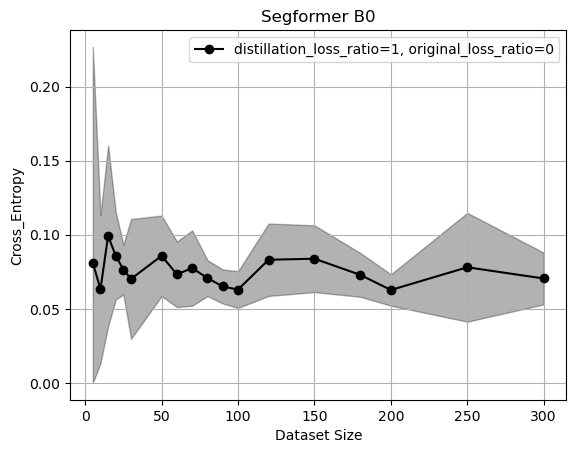

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0610')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.png"))

plt.show()